In [2]:
import cv2
import numpy as np
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from skimage import measure
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchvision.transforms.functional as TF
from PIL import Image
from utils.preprocess import denoise_with_sitk, denoise_with_ants, enhance_vessels_with_frangi
from tqdm import tqdm
import shutil
from utils import dataset, losses, metrics, misc, preprocess, segmentation_model, vizualization

misc.seed_everything(42)

In [28]:
def measure_vertebral_arteries(mask_path):

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Сортировка контуров слева направо
    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            centroids.append((cx, cy, contour))
    
    # Сортировка по x-координате (слева направо)
    centroids.sort(key=lambda x: x[0])
    
    diameters = []
    for _, _, contour in centroids:
        area = cv2.contourArea(contour)
        diameter_from_area = 2 * np.sqrt(area / np.pi)
        diameters.append(diameter_from_area)

    while len(diameters) < 2:
        diameters.append(0)
    
    return tuple(diameters)

def create_vertebral_artery_dataset(pairs):

    data = []
    
    for img_path, mask_path in pairs:
        if not os.path.exists(img_path) or not os.path.exists(mask_path):
            print(f"Пропускаю отсутствующие файлы: {img_path} или {mask_path}")
            continue
        
        left_diameter, right_diameter = measure_vertebral_arteries(mask_path)
        
        data.append({
            'image_path': img_path,
            'mask_path': mask_path,
            'left_diameter': left_diameter,
            'right_diameter': right_diameter
        })
    
    # Создание DataFrame
    return pd.DataFrame(data)

In [29]:
data_dir = './new_dataset' # менять путь для датасетов с наложенными фильтрами

train_image_files = glob.glob(os.path.join(data_dir, 'train', '*.jpg'))
train_mask_files = [f.replace('.jpg', '-VA.png') for f in train_image_files]
train_pairs = [(img, mask) for img, mask in zip(train_image_files, train_mask_files)]

val_image_files = glob.glob(os.path.join(data_dir, 'val', '*.jpg'))
val_mask_files = [f.replace('.jpg', '-VA.png') for f in val_image_files]
val_pairs = [(img, mask) for img, mask in zip(val_image_files, val_mask_files)]

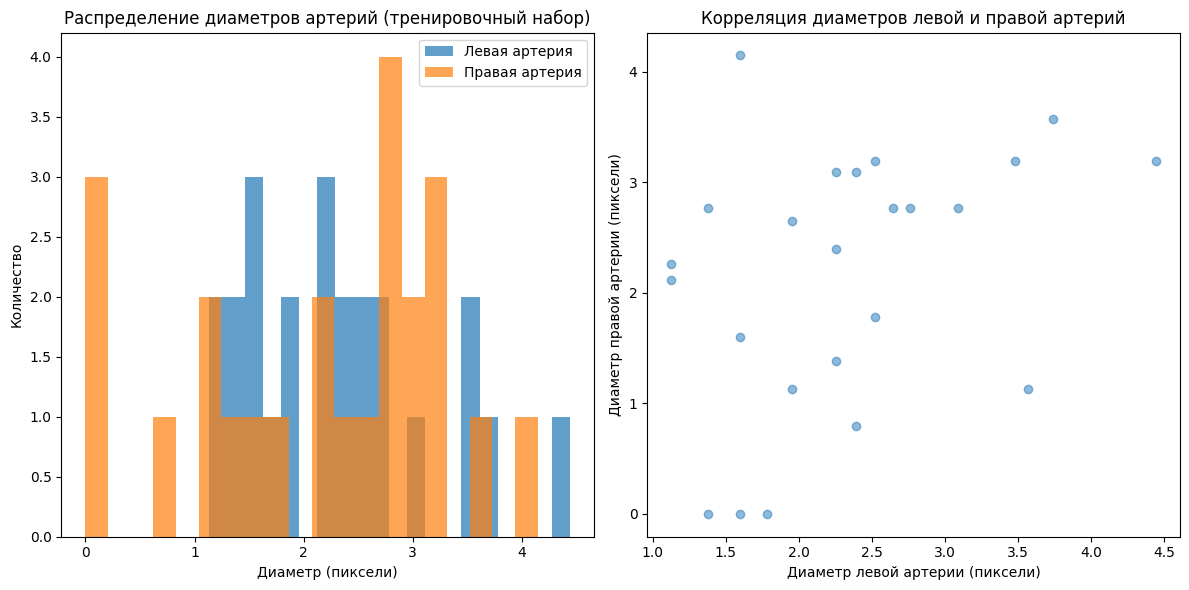

Статистика по тренировочному набору:
       left_diameter  right_diameter
count      24.000000       24.000000
mean        2.326510        2.156217
std         0.863653        1.173196
min         1.128379        0.000000
25%         1.595769        1.318577
50%         2.256758        2.519969
75%         2.675701        3.090194
max         4.442433        4.145930

Статистика по валидационному набору:
       left_diameter  right_diameter
count       6.000000        6.000000
mean        2.598253        1.814668
std         0.900874        1.380318
min         1.784124        0.000000
25%         2.029997        0.880508
50%         2.256758        1.761016
75%         2.957843        2.916059
max         4.145930        3.477898


In [31]:
# Создаем датасеты для обучения и валидации
train_dataset = create_vertebral_artery_dataset(train_pairs)
val_dataset = create_vertebral_artery_dataset(val_pairs)

# Сохраняем датасеты в CSV
# train_dataset.to_csv('train_vertebral_arteries.csv', index=False)
# val_dataset.to_csv('val_vertebral_arteries.csv', index=False)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(train_dataset['left_diameter'], bins=20, alpha=0.7, label='Левая артерия')
plt.hist(train_dataset['right_diameter'], bins=20, alpha=0.7, label='Правая артерия')
plt.title('Распределение диаметров артерий (тренировочный набор)')
plt.xlabel('Диаметр (пиксели)')
plt.ylabel('Количество')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(train_dataset['left_diameter'], train_dataset['right_diameter'], alpha=0.5)
plt.title('Корреляция диаметров левой и правой артерий')
plt.xlabel('Диаметр левой артерии (пиксели)')
plt.ylabel('Диаметр правой артерии (пиксели)')

plt.tight_layout()
plt.savefig('diameter_analysis.png')
plt.show()

print(f"Статистика по тренировочному набору:\n{train_dataset[['left_diameter', 'right_diameter']].describe()}")
print(f"\nСтатистика по валидационному набору:\n{val_dataset[['left_diameter', 'right_diameter']].describe()}")

In [33]:
class VertebralArteryDataset(Dataset):
    def __init__(self, dataframe, denoise=None, transform=None):
        """
        Args:
            dataframe: Pandas DataFrame с колонками image_path, left_diameter, right_diameter
            transform: Опциональные преобразования изображений
        """
        self.dataframe = dataframe
        self.transform = transform
        self.denoise = denoise
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        left_diameter = self.dataframe.iloc[idx]['left_diameter']
        right_diameter = self.dataframe.iloc[idx]['right_diameter']
        
        # Загрузка изображения
        image = Image.open(img_path).convert('RGB')

        if self.denoise == "sitk":
            image_array = np.array(image)
            
            # Применяем шумоподавление к каждому каналу изображения
            denoised_image = np.zeros_like(image_array)
            for i in range(3):
                denoised_image[:, :, i] = denoise_with_sitk(image_array[:, :, i])
            
            image = Image.fromarray(denoised_image.astype('uint8'))
        
        # Преобразования
        if self.transform:
            image = self.transform(image)
        
        # Целевые значения - диаметры артерий
        target = torch.tensor([left_diameter, right_diameter], dtype=torch.float32)
        
        return image, target

# Определение преобразований
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Создание датасетов для обучения
train_ds = VertebralArteryDataset(train_dataset, transform=train_transform)
val_ds = VertebralArteryDataset(val_dataset, transform=val_transform)

# Создание датавалодеров
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False)

In [46]:
class VertebralArteryRegressor(nn.Module):
    def __init__(self, pretrained=True):
        super(VertebralArteryRegressor, self).__init__()
        # Загрузка предобученной ResNet50
        self.resnet = models.resnet50(pretrained=pretrained)
        
        # Заменяем последний слой для регрессии двух значений
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(in_features, 2048),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 2)  # 2 выхода: диаметр левой и правой артерий
        )
    
    def forward(self, x):
        return self.resnet(x)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30):
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(num_epochs):
        print(f'Эпоха {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Тренировочная фаза
        model.train()
        train_loss = 0.0
        
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Обнуление градиентов
            optimizer.zero_grad()
            
            # Прямой проход
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Обратное распространение и оптимизация
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
        
        train_loss = train_loss / len(train_loader.dataset)
        
        # Валидационная фаза
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item() * inputs.size(0)
        
        val_loss = val_loss / len(val_loader.dataset)
        
        # Обновление планировщика скорости обучения
        scheduler.step(val_loss)
        
        # Сохранение лучшей модели
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'diameter_weights/diameter_best_weights.pth') # можно переименовать модель
            print(f'Модель сохранена с val_loss: {val_loss:.4f}')
        
        # Запись истории
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        print(f'Средний квадратный корень ошибки (RMSE): {np.sqrt(val_loss):.4f} пикселей')
    
    return history

def evaluate_model(model, dataloader):
    model.eval()
    predictions = []
    ground_truth = []
    image_paths = []
    
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dataloader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            predictions.extend(outputs.cpu().numpy())
            ground_truth.extend(targets.numpy())
            
            # Сохранение путей к изображениям
            batch_indices = [i * dataloader.batch_size + j for j in range(len(outputs))]
            for idx in batch_indices:
                if idx < len(dataloader.dataset):
                    image_paths.append(dataloader.dataset.dataframe.iloc[idx]['image_path'])
    
    return np.array(predictions), np.array(ground_truth), image_paths

def calculate_metrics(preds, gt):
    """
    Рассчитывает различные метрики сравнения предсказаний с истинными значениями.
    
    Args:
        preds: numpy array предсказаний
        gt: numpy array истинных значений (ground truth)
    
    Returns:
        mae: средняя абсолютная ошибка
        rmse: корень из среднеквадратичной ошибки
        rel_mae: относительная абсолютная ошибка (в процентах)
        cv: коэффициент вариации (в процентах)
    """
    # Средняя абсолютная ошибка
    mae = np.mean(np.abs(preds - gt), axis=0)
    
    # Корень из среднеквадратичной ошибки
    rmse = np.sqrt(np.mean((preds - gt)**2, axis=0))
    
    # Относительная абсолютная ошибка (в процентах)
    rel_mae = np.mean(np.abs(preds - gt) / (gt + 1e-8) * 100, axis=0)
    
    # Коэффициент вариации (стандартное отклонение / среднее значение)
    # Формула: CV = (std / mean) * 100%
    # Для целей сравнения предсказаний и истинных значений, рассчитаем CV для разности
    diff = preds - gt
    mean_diff = np.mean(diff, axis=0)
    std_diff = np.std(diff, axis=0)
    # Избегаем деления на ноль
    cv = (std_diff / (np.abs(mean_diff)))
    
    return mae, rmse, rel_mae, cv

In [47]:
# Инициализация модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VertebralArteryRegressor(pretrained=True).to(device)
model.load_state_dict(torch.load('diameter_weights/best_vertebral_artery_augmented_ants.pth', map_location=device))

# Функция потерь и оптимизатор
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

Эпоха 1/1
----------
Модель сохранена с val_loss: 3.8590
Train Loss: 13.7492, Val Loss: 3.8590
Средний квадратный корень ошибки (RMSE): 1.9644 пикселей


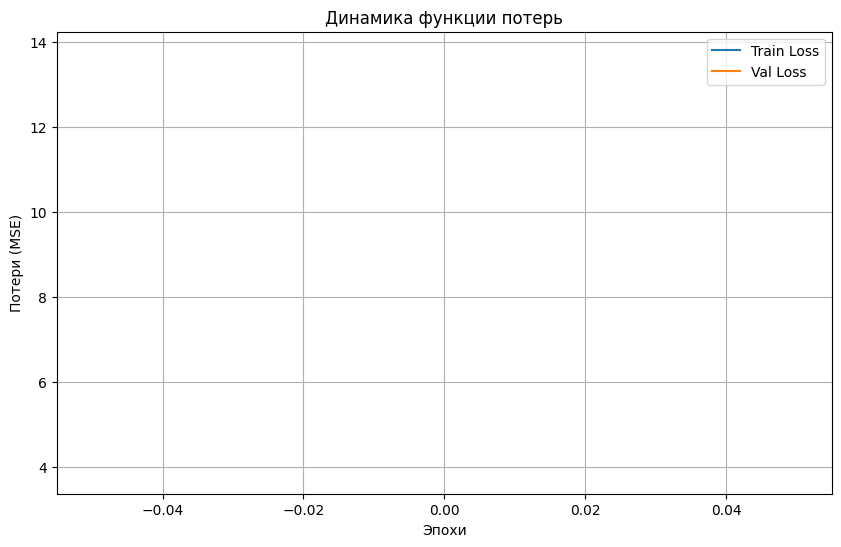

In [48]:
# Обучение модели
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=1)

# # Визуализация процесса обучения
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Динамика функции потерь')
plt.xlabel('Эпохи')
plt.ylabel('Потери (MSE)')
plt.legend()
plt.grid(True)
plt.savefig('training_history.png')
plt.show()